# Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
%config InlineBackend.figure_format='svg'

# Data Processing
## Preprocessing dataset

In [16]:
df_Bos=pd.read_excel('./Data/raw/BOS Bookings 2017 - 2019.xlsx')

In [32]:
df = df_Bos.copy()

In [50]:
def process(df):    
    # drop unused features
    tmp = df.drop(columns=['DESTINATION', 'total_rev', 'RPM'])
    
    # rename
    tmp.rename(columns={'FILE_SNPSHT_DT': 'Obs_dt', 'OD_DEP_DT': 'Dep_dt'}, inplace=True)
    
    # convert string to date time format
    tmp[['Obs_dt','Dep_dt']] = tmp[['Obs_dt','Dep_dt']].apply(pd.to_datetime)
    
    # add "Cumulative": cumulative bookings
    tmp = tmp.groupby(['Obs_dt', 'Dep_dt'], as_index=False).sum().rename(columns={'total_pax': 'Cumulative'})
    
    # order by the "Dep_dt" and "Obs_dt"
    tmp.sort_values(['Dep_dt', 'Obs_dt'], inplace=True)
    
    # compute daily pax from cumulative pax
    ## create empty dataframe
    res = tmp.iloc[0:0]
    
    ## traversal for all departure dates
    for dt in tmp['Dep_dt'].unique():
        test = tmp.loc[tmp['Dep_dt'] == dt]
        test['Daily'] = test['Cumulative']
        test.loc[1:, 'Daily'] = test['Daily'].diff().loc[1:].values
        res = pd.concat([res, test.loc[1:]], ignore_index=True)
    return res[["Obs_dt", "Dep_dt", "Daily", "Cumulative"]]

In [84]:
Boston_dataset = process(df)
Boston_dataset

/home/denn1s/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/denn1s/miniconda3/envs/tf1/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/denn1s/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To acce

,Obs_dt,Dep_dt,Daily,Cumulative
0,2016-10-03,2017-01-01,9.0,471
1,2016-10-04,2017-01-01,6.0,477
2,2016-10-05,2017-01-01,6.0,483
3,2016-10-06,2017-01-01,11.0,494
4,2016-10-07,2017-01-01,4.0,498
...,...,...,...,...
308409,2019-10-27,2019-10-31,180.0,3834
308410,2019-10-28,2019-10-31,166.0,4000
308411,2019-10-29,2019-10-31,299.0,4299
308412,2019-10-30,2019-10-31,908.0,5207


## Training set and Test set

- remove outliers

In [85]:
Boston_dataset = Boston_dataset[Boston_dataset['Daily']>=0].reset_index(drop=True)

- training set and test set

In [86]:
train_data = Boston_dataset[Boston_dataset['Dep_dt'] < '2019-01-01']
test_data = Boston_dataset[Boston_dataset['Dep_dt'] >= '2019-01-01']

In [87]:
a = train_data['Daily'].values.reshape(-1, 1)
b = test_data['Daily'].values.reshape(-1, 1)

In [88]:
a.shape

(206272, 1)

In [89]:
b.shape

(97289, 1)

- normalization

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
a = scaler.fit_transform(a)
b = scaler.transform(b)

In [92]:
train_data['Daily'] = a
test_data['Daily'] = b

/home/denn1s/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/denn1s/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Training Data Preparation

In [131]:
def create_input_ouput(df, input_timestep, output_timestep):
    input_data, output_data = [], []
    df_group = df.groupby(['Dep_dt'])  
    
    for dt in df_group.groups.keys():
        tmp = df_group.get_group(dt)
        for i in range(tmp.index[0], tmp.index[-1] - input_timestep
                       - output_timestep + 2):
            test = []
            for j in range(input_timestep):
                test.append(tmp['Daily'][i + j])
            input_data.append(test)
            
            test = []
            for j in range(output_timestep):
                test.append(tmp['Daily'][i + input_timestep + j])
            output_data.append(test)
    return np.array(input_data), np.array(output_data)

In [132]:
train_input, train_output = create_input_ouput(train_data, 
                                               input_timestep=3,
                                               output_timestep=1)

In [133]:
train_input.shape

(204082, 3)

In [134]:
train_output.shape

(204082, 1)

## Testing Data Preparation

In [135]:
test_input, test_output = create_input_ouput(test_data,
                                             input_timestep=3,
                                             output_timestep=1)

In [136]:
test_input.shape

(96377, 3)

In [137]:
test_output.shape

(96377, 1)

## Finalize

In [144]:
x_train = train_input.reshape(train_input.shape[0],3,1)
y_train = train_output.reshape(train_output.shape[0],1)

In [145]:
x_train.shape

(204082, 3, 1)

In [146]:
y_train.shape

(204082, 1)

In [147]:
x_train[0]

array([[0.00297226],
       [0.00198151],
       [0.00198151]])

In [148]:
y_train[0]

array([0.00363276])

# LSTM Model

## modeling

In [149]:
latent_dimension = 64
batch_size = 32

In [150]:
model = keras.Sequential()
model.add(keras.layers.LSTM(latent_dimension, dropout=0.2, 
                            recurrent_dropout=0.1, input_shape=(3,1)))
model.add(keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## training

In [151]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=25, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
204082/204082 - 30s - loss: 6.0587e-04
Epoch 2/25
204082/204082 - 29s - loss: 4.4554e-04
Epoch 3/25
204082/204082 - 30s - loss: 3.8092e-04
Epoch 4/25
204082/204082 - 30s - loss: 3.7169e-04
Epoch 5/25
204082/204082 - 30s - loss: 3.7057e-04
Epoch 6/25
204082/204082 - 30s - loss: 3.5955e-04
Epoch 7/25
204082/204082 - 30s - loss: 3.5007e-04
Epoch 8/25
204082/204082 - 31s - loss: 3.3787e-04
Epoch 9/25
204082/204082 - 30s - loss: 3.3665e-04
Epoch 10/25
204082/204082 - 30s - loss: 3.3530e-04
Epoch 11/25
204082/204082 - 30s - loss: 3.2917e-04
Epoch 12/25
204082/204082 - 30s - loss: 3.3239e-04
Epoch 13/25
204082/204082 - 30s - loss: 3.2337e-04
Epoch 14/25
204082/204082 - 30s - loss: 3.1622e-04
Epoch 15/25
204082/204082 - 30s - loss: 3.1632e-04
Epoch 16/25
204082/204082 - 30s - loss: 3.1162e-04
Epoch 17/25
204082/204082 - 30s - loss: 3.0579e-04
Epoch 18/25
204082/204082 - 30s - loss: 2.9847e-

## prediction

In [152]:
x_test = test_input.reshape(test_input.shape[0],3,1)
y_test = test_output.reshape(test_output.shape[0],1)

In [153]:
trainPredict = model.predict(x_train, batch_size=32)

model.reset_states()

testPredict = model.predict(x_test, batch_size=32)

## validation

In [156]:
# invert predictions
train_y_pred = scaler.inverse_transform(trainPredict)
train_y = scaler.inverse_transform(y_train)
test_y_pred = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform(y_test)

In [175]:
from sklearn.metrics import mean_absolute_error

print("mse for training set:", mean_absolute_error(train_y,train_y_pred))

mse for training set: 12.05561707505295


In [176]:
print("mse for testing set:", mean_absolute_error(test_y,test_y_pred))

mse for testing set: 10.639250858436478


- visualization

In [171]:
def plot(y_true, y_pred, version, flag, period=80):
    plt.figure(figsize=(10,6))
    plt.plot(y_true[:period],label='Actual')
    plt.plot(y_pred[:period],label='Predicted')
    plt.title('Model' + version + ' for ' + flag)
    plt.ylabel('Bookings', rotation=0)
    plt.xlabel('AP')
    plt.legend()
    plt.show()

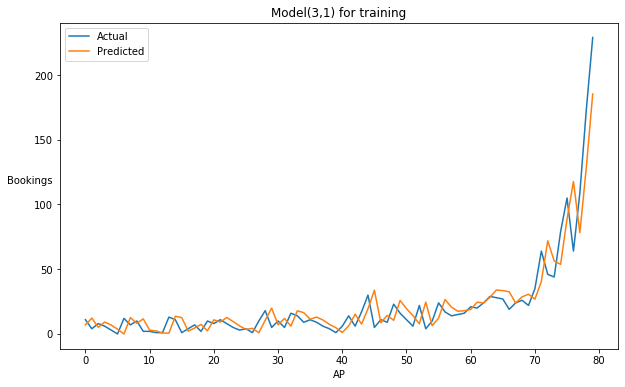

In [172]:
plot(train_y, train_y_pred, version='(3,1)', flag='training')

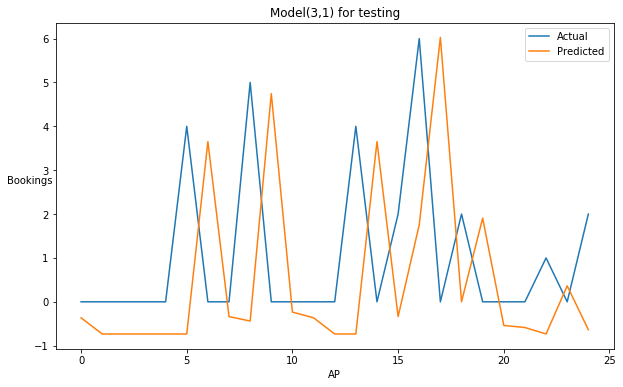

In [173]:
plot(test_y, test_y_pred, version='(3,1)', flag='testing', period=25)